<a href="https://colab.research.google.com/github/InowaR/colab/blob/main/path_planning.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

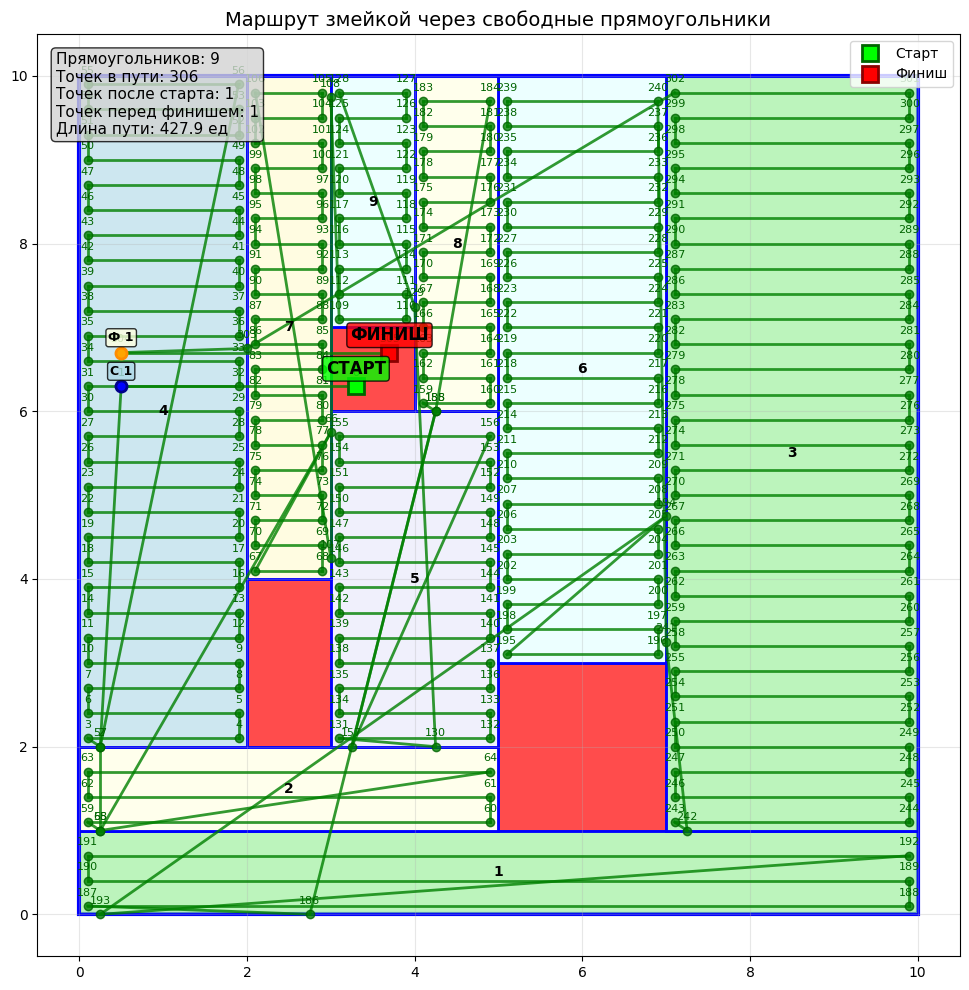

In [65]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.patches import Polygon, Rectangle
from typing import List, Tuple, Optional
import random

class FreeRectangle:
    def __init__(self, vertices):
        self.vertices = vertices
        self.center = np.mean(vertices, axis=0)
        self.x1 = min(v[0] for v in vertices)
        self.x2 = max(v[0] for v in vertices)
        self.y1 = min(v[1] for v in vertices)
        self.y2 = max(v[1] for v in vertices)
        self.width = self.x2 - self.x1
        self.height = self.y2 - self.y1

    def get_boundary_points(self, step=0.5) -> List[np.ndarray]:
        """Генерирует точки на границе прямоугольника"""
        points = []
        # Нижняя граница
        x_bottom = np.arange(self.x1 + step/2, self.x2, step)
        points.extend([np.array([x, self.y1]) for x in x_bottom])

        # Правая граница
        y_right = np.arange(self.y1 + step/2, self.y2, step)
        points.extend([np.array([self.x2, y]) for y in y_right])

        # Верхняя граница
        x_top = np.arange(self.x2 - step/2, self.x1, -step)
        points.extend([np.array([x, self.y2]) for x in x_top])

        # Левая граница
        y_left = np.arange(self.y2 - step/2, self.y1, -step)
        points.extend([np.array([self.x1, y]) for y in y_left])

        return points

class Obstacle:
    def __init__(self, vertices):
        self.vertices = vertices
        self.x1 = min(v[0] for v in vertices)
        self.x2 = max(v[0] for v in vertices)
        self.y1 = min(v[1] for v in vertices)
        self.y2 = max(v[1] for v in vertices)

    def get_bounds(self) -> Tuple[float, float, float, float]:
        return self.x1, self.y1, self.x2, self.y2

class SnakeTrajectoryPlanner:
    def __init__(self, border_offset=0.1, step_y=0.1):
        self.border_offset = border_offset
        self.step_y = step_y

    def generate_snake_trajectory(self, rectangle: FreeRectangle) -> List[np.ndarray]:
        """Генерирует траекторию змейкой внутри прямоугольника"""
        x_min, x_max = rectangle.x1, rectangle.x2
        y_min, y_max = rectangle.y1, rectangle.y2

        x_coords = np.array([x_min + self.border_offset, x_max - self.border_offset])
        y_coords = np.arange(y_min + self.border_offset, y_max - self.border_offset, self.step_y)

        if len(y_coords) == 0:
            return [rectangle.center]

        points = []
        for i, y in enumerate(y_coords):
            if i % 2 == 0:  # Четные строки - слева направо
                for x in x_coords:
                    points.append(np.array([x, y]))
            else:  # Нечетные строки - справа налево
                for x in reversed(x_coords):
                    points.append(np.array([x, y]))

        return points

class PathFinder:
    def __init__(self, rectangles: List[FreeRectangle], obstacles: List[Obstacle],
                 start_point: np.ndarray, end_point: np.ndarray,
                 start_waypoints: List[np.ndarray] = None, end_waypoints: List[np.ndarray] = None):
        self.rectangles = rectangles
        self.obstacles = obstacles
        self.start_point = start_point
        self.end_point = end_point
        self.start_waypoints = start_waypoints if start_waypoints else []
        self.end_waypoints = end_waypoints if end_waypoints else []
        self.snake_planner = SnakeTrajectoryPlanner()

    def can_connect_directly(self, point1: np.ndarray, point2: np.ndarray) -> bool:
        """Проверяет, можно ли соединить две точки напрямую без пересечения препятствий"""
        for obstacle in self.obstacles:
            if self.line_intersects_obstacle(point1, point2, obstacle):
                return False
        return True

    def line_intersects_obstacle(self, p1: np.ndarray, p2: np.ndarray, obstacle: Obstacle) -> bool:
        """Проверяет пересечение отрезка с препятствием"""
        x1, y1, x2, y2 = obstacle.get_bounds()

        # Проверяем, лежат ли точки внутри препятствия
        if (x1 <= p1[0] <= x2 and y1 <= p1[1] <= y2) or \
           (x1 <= p2[0] <= x2 and y1 <= p2[1] <= y2):
            return True

        # Проверяем пересечение с каждой стороной препятствия
        sides = [
            [(x1, y1), (x2, y1)],  # нижняя
            [(x2, y1), (x2, y2)],  # правая
            [(x2, y2), (x1, y2)],  # верхняя
            [(x1, y2), (x1, y1)]   # левая
        ]

        for side in sides:
            if self.lines_intersect(p1, p2, side[0], side[1]):
                return True

        return False

    def lines_intersect(self, a1: np.ndarray, a2: np.ndarray, b1: Tuple[float, float], b2: Tuple[float, float]) -> bool:
        """Проверяет пересечение двух отрезков"""
        def ccw(A, B, C):
            return (C[1]-A[1]) * (B[0]-A[0]) > (B[1]-A[1]) * (C[0]-A[0])

        return ccw(a1, b1, b2) != ccw(a2, b1, b2) and ccw(a1, a2, b1) != ccw(a1, a2, b2)

    def find_connection_point(self, rect1: FreeRectangle, rect2: FreeRectangle) -> Optional[Tuple[np.ndarray, np.ndarray]]:
        """Находит точки соединения на границах двух прямоугольников"""
        boundary1 = rect1.get_boundary_points()
        boundary2 = rect2.get_boundary_points()

        for point1 in boundary1:
            for point2 in boundary2:
                if self.can_connect_directly(point1, point2):
                    return point1, point2
        return None

    def find_closest_rectangle_to_point(self, point: np.ndarray) -> Optional[FreeRectangle]:
        """Находит ближайший прямоугольник к заданной точке"""
        if not self.rectangles:
            return None

        closest_rect = None
        min_distance = float('inf')

        for rect in self.rectangles:
            distance = np.linalg.norm(rect.center - point)
            if distance < min_distance:
                min_distance = distance
                closest_rect = rect

        return closest_rect

    def find_connection_to_rectangle(self, point: np.ndarray, rect: FreeRectangle) -> Optional[np.ndarray]:
        """Находит точку соединения от точки к прямоугольнику"""
        boundary_points = rect.get_boundary_points()

        for boundary_point in boundary_points:
            if self.can_connect_directly(point, boundary_point):
                return boundary_point
        return None

    def build_complete_path(self) -> List[np.ndarray]:
        """Строит полный путь через все прямоугольники с начальной и конечной точками"""
        if len(self.rectangles) < 1:
            return []

        sorted_rects = sorted(self.rectangles, key=lambda r: (r.center[0], r.center[1]))
        complete_path = []

        # Добавляем стартовую точку и точки после старта
        complete_path.append(self.start_point)

        # Добавляем точки после старта
        for waypoint in self.start_waypoints:
            complete_path.append(waypoint)

        # Находим ближайший прямоугольник к последней точке после старта
        last_start_point = self.start_waypoints[-1] if self.start_waypoints else self.start_point
        start_rect = self.find_closest_rectangle_to_point(last_start_point)
        if start_rect:
            start_connection = self.find_connection_to_rectangle(last_start_point, start_rect)
            if start_connection is not None:
                complete_path.append(start_connection)

        # Обрабатываем все прямоугольники
        for i, rect in enumerate(sorted_rects):
            snake_path = self.snake_planner.generate_snake_trajectory(rect)

            if i == 0:
                complete_path.extend(snake_path)
            else:
                prev_rect = sorted_rects[i-1]
                connection = self.find_connection_point(prev_rect, rect)

                if connection is not None:
                    point1, point2 = connection
                    complete_path.extend([point1, point2])
                    complete_path.extend(snake_path)
                else:
                    complete_path.extend(snake_path)

        # Добавляем соединение с точками перед финишем
        if self.end_waypoints:
            end_rect = self.find_closest_rectangle_to_point(self.end_waypoints[0])
        else:
            end_rect = self.find_closest_rectangle_to_point(self.end_point)

        if end_rect and complete_path:  # Проверяем, что путь не пустой
            last_rect_point = complete_path[-1]
            end_connection = self.find_connection_to_rectangle(last_rect_point, end_rect)
            if end_connection is not None:
                complete_path.append(end_connection)

        # Добавляем точки перед финишем
        for waypoint in self.end_waypoints:
            complete_path.append(waypoint)

        # Добавляем конечную точку
        complete_path.append(self.end_point)

        return complete_path

class SpacePartitioner:
    def __init__(self, width: float = 10, height: float = 10):
        self.width = width
        self.height = height

    def merge_rectangles(self, obstacles: List[Obstacle]) -> List[FreeRectangle]:
        """Объединяет ячейки сетки в большие прямоугольники"""
        x_coords = sorted(set([0, self.width] +
                             [point[0] for obstacle in obstacles for point in obstacle.vertices]))
        y_coords = sorted(set([0, self.height] +
                             [point[1] for obstacle in obstacles for point in obstacle.vertices]))

        grid = np.zeros((len(y_coords)-1, len(x_coords)-1), dtype=bool)

        for obstacle in obstacles:
            obs_x_min = obstacle.x1
            obs_x_max = obstacle.x2
            obs_y_min = obstacle.y1
            obs_y_max = obstacle.y2

            for i in range(len(x_coords)-1):
                for j in range(len(y_coords)-1):
                    cell_x_min, cell_x_max = x_coords[i], x_coords[i+1]
                    cell_y_min, cell_y_max = y_coords[j], y_coords[j+1]

                    if (cell_x_min < obs_x_max and cell_x_max > obs_x_min and
                        cell_y_min < obs_y_max and cell_y_max > obs_y_min):
                        grid[j, i] = True

        quadrilaterals = []
        visited = np.zeros_like(grid)

        for j in range(len(y_coords)-1):
            i = 0
            while i < len(x_coords)-1:
                if visited[j, i] or grid[j, i]:
                    i += 1
                    continue

                width = 1
                while (i + width < len(x_coords)-1 and
                       not visited[j, i + width] and
                       not grid[j, i + width]):
                    width += 1

                height = 1
                can_extend_height = True
                while can_extend_height and j + height < len(y_coords)-1:
                    for w in range(width):
                        if visited[j + height, i + w] or grid[j + height, i + w]:
                            can_extend_height = False
                            break
                    if can_extend_height:
                        height += 1

                quad = [
                    [x_coords[i], y_coords[j]],
                    [x_coords[i + width], y_coords[j]],
                    [x_coords[i + width], y_coords[j + height]],
                    [x_coords[i], y_coords[j + height]]
                ]

                quadrilaterals.append(FreeRectangle(quad))

                for h in range(height):
                    for w in range(width):
                        if j + h < len(y_coords)-1 and i + w < len(x_coords)-1:
                            visited[j + h, i + w] = True

                i += width

        return quadrilaterals

class Visualizer:
    def __init__(self, width: float = 10, height: float = 10):
        self.width = width
        self.height = height
        self.fig, self.ax = plt.subplots(figsize=(12, 10))

    def get_random_light_color(self):
        """Генерирует случайный светлый цвет"""
        colors = ['lightpink', 'lightblue', 'lightyellow', 'lightgreen', 'lightcyan',
                  'lavender', 'peachpuff', 'paleturquoise', 'lemonchiffon', 'mistyrose']
        return random.choice(colors)

    def plot_scene(self, rectangles: List[FreeRectangle], obstacles: List[Obstacle],
                   path: List[np.ndarray], start_point: np.ndarray, end_point: np.ndarray,
                   start_waypoints: List[np.ndarray], end_waypoints: List[np.ndarray]):
        """Визуализирует всю сцену с прямоугольниками, препятствиями и путем"""
        self.ax.clear()

        # Рисуем внешнюю границу 10x10 синей сплошной линией
        boundary = Rectangle((0, 0), self.width, self.height,
                           fill=False, edgecolor='blue', linewidth=3)
        self.ax.add_patch(boundary)

        # Рисуем препятствия
        for obstacle in obstacles:
            obstacle_patch = Polygon(obstacle.vertices, fill=True,
                                   facecolor='red', alpha=0.7,
                                   edgecolor='blue', linewidth=2)
            self.ax.add_patch(obstacle_patch)

        # Рисуем свободные прямоугольники со случайными светлыми цветами и синим контуром
        for i, rect in enumerate(rectangles):
            # Внутренняя заливка случайным светлым цветом
            quad_patch = Polygon(rect.vertices, fill=True,
                               facecolor=self.get_random_light_color(), alpha=0.6)
            self.ax.add_patch(quad_patch)

            # Синий контур прямоугольника
            border_patch = Polygon(rect.vertices, fill=False,
                                 edgecolor='blue', linewidth=2)
            self.ax.add_patch(border_patch)

            # Подписываем прямоугольники
            center = rect.center
            self.ax.text(center[0], center[1], str(i+1), ha='center', va='center',
                        fontsize=10, fontweight='bold')

        # Рисуем полный путь зеленым цветом
        if len(path) > 1:
            path_array = np.array(path)

            # Рисуем линии пути зеленым цветом
            for i in range(len(path_array) - 1):
                p1, p2 = path_array[i], path_array[i+1]
                self.ax.plot([p1[0], p2[0]], [p1[1], p2[1]], color='green',
                           linewidth=2, alpha=0.8)

            # Рисуем точки пути зеленым цветом
            self.ax.plot(path_array[:, 0], path_array[:, 1], 'o', markersize=6,
                       markerfacecolor='green', markeredgecolor='darkgreen',
                       markeredgewidth=1, alpha=0.8)

            # Подписываем все точки пути
            for i, point in enumerate(path):
                self.ax.text(point[0], point[1] + 0.1, f'{i}',
                           ha='center', va='bottom', fontsize=8, color='darkgreen')

        # Рисуем стартовую и финишную точки
        self.ax.plot(start_point[0], start_point[1], 's', markersize=12,
                   markerfacecolor='lime', markeredgecolor='darkgreen',
                   markeredgewidth=2, label='Старт')
        self.ax.plot(end_point[0], end_point[1], 's', markersize=12,
                   markerfacecolor='red', markeredgecolor='darkred',
                   markeredgewidth=2, label='Финиш')

        # Рисуем точки после старта (синие)
        for i, waypoint in enumerate(start_waypoints):
            self.ax.plot(waypoint[0], waypoint[1], 'o', markersize=8,
                       markerfacecolor='blue', markeredgecolor='darkblue',
                       markeredgewidth=2)
            self.ax.text(waypoint[0], waypoint[1] + 0.1, f'C {i+1}',
                       ha='center', va='bottom', fontsize=9, fontweight='bold',
                       bbox=dict(boxstyle="round,pad=0.2", facecolor='lightblue', alpha=0.8))

        # Рисуем точки перед финишем (оранжевые)
        for i, waypoint in enumerate(end_waypoints):
            self.ax.plot(waypoint[0], waypoint[1], 'o', markersize=8,
                       markerfacecolor='orange', markeredgecolor='darkorange',
                       markeredgewidth=2)
            self.ax.text(waypoint[0], waypoint[1] + 0.1, f'Ф {i+1}',
                       ha='center', va='bottom', fontsize=9, fontweight='bold',
                       bbox=dict(boxstyle="round,pad=0.2", facecolor='lightyellow', alpha=0.8))

        # Подписываем старт и финиш
        self.ax.text(start_point[0], start_point[1] + 0.1, 'СТАРТ',
                   ha='center', va='bottom', fontsize=12, fontweight='bold',
                   bbox=dict(boxstyle="round,pad=0.2", facecolor='lime', alpha=0.8))
        self.ax.text(end_point[0], end_point[1] + 0.1, 'ФИНИШ',
                   ha='center', va='bottom', fontsize=12, fontweight='bold',
                   bbox=dict(boxstyle="round,pad=0.2", facecolor='red', alpha=0.8))

        # Настройки отображения
        self.ax.set_xlim(-0.5, self.width + 0.5)
        self.ax.set_ylim(-0.5, self.height + 0.5)
        self.ax.set_aspect('equal')
        self.ax.grid(True, alpha=0.3)
        self.ax.set_title('Маршрут змейкой через свободные прямоугольники', fontsize=14)
        self.ax.legend(loc='upper right')

        # Добавляем информационную панель
        info_text = (f'Прямоугольников: {len(rectangles)}\n'
                    f'Точек в пути: {len(path)}\n'
                    f'Точек после старта: {len(start_waypoints)}\n'
                    f'Точек перед финишем: {len(end_waypoints)}\n'
                    f'Длина пути: {self._calculate_path_length(path):.1f} ед')

        self.ax.text(0.02, 0.98, info_text, transform=self.ax.transAxes, fontsize=11,
                    verticalalignment='top',
                    bbox=dict(boxstyle="round", facecolor='lightgray', alpha=0.8))

    def _calculate_path_length(self, path: List[np.ndarray]) -> float:
        """Вычисляет общую длину пути"""
        if len(path) < 2:
            return 0.0
        total_length = 0.0
        for i in range(len(path) - 1):
            total_length += np.linalg.norm(path[i+1] - path[i])
        return total_length

    def show(self):
        """Показывает график"""
        plt.tight_layout()
        plt.show()

def main():
    # Параметры
    MAP_SIZE = 10
    BORDER_OFFSET = 0.1
    STEP_Y = 0.3

    # Основные препятствия
    obstacles_data = [
        [[2, 2], [3, 2], [3, 4], [2, 4]],
        [[5, 1], [7, 1], [7, 3], [5, 3]],
        [[3, 6], [4, 6], [4, 7], [3, 7]],
    ]

    obstacles = [Obstacle(np.array(obs)) for obs in obstacles_data]

    # Точки старта и финиша
    start_point = np.array([3.3, 6.3])
    end_point = np.array([3.7, 6.7])

    # Точки после старта
    start_waypoints = [
        np.array([0.5, 6.3])
    ]

    # Точки перед финишем
    end_waypoints = [
        np.array([0.5, 6.7])
    ]

    # Разбиваем пространство
    partitioner = SpacePartitioner(width=MAP_SIZE, height=MAP_SIZE)
    rectangles = partitioner.merge_rectangles(obstacles)

    # Настраиваем планировщик с пользовательскими параметрами
    snake_planner = SnakeTrajectoryPlanner(border_offset=BORDER_OFFSET, step_y=STEP_Y)
    path_finder = PathFinder(rectangles, obstacles, start_point, end_point,
                           start_waypoints, end_waypoints)
    path_finder.snake_planner = snake_planner

    # Строим путь
    path = path_finder.build_complete_path()

    # Визуализируем
    visualizer = Visualizer(width=MAP_SIZE, height=MAP_SIZE)
    visualizer.plot_scene(rectangles, obstacles, path, start_point, end_point,
                         start_waypoints, end_waypoints)
    visualizer.show()

if __name__ == "__main__":
    main()

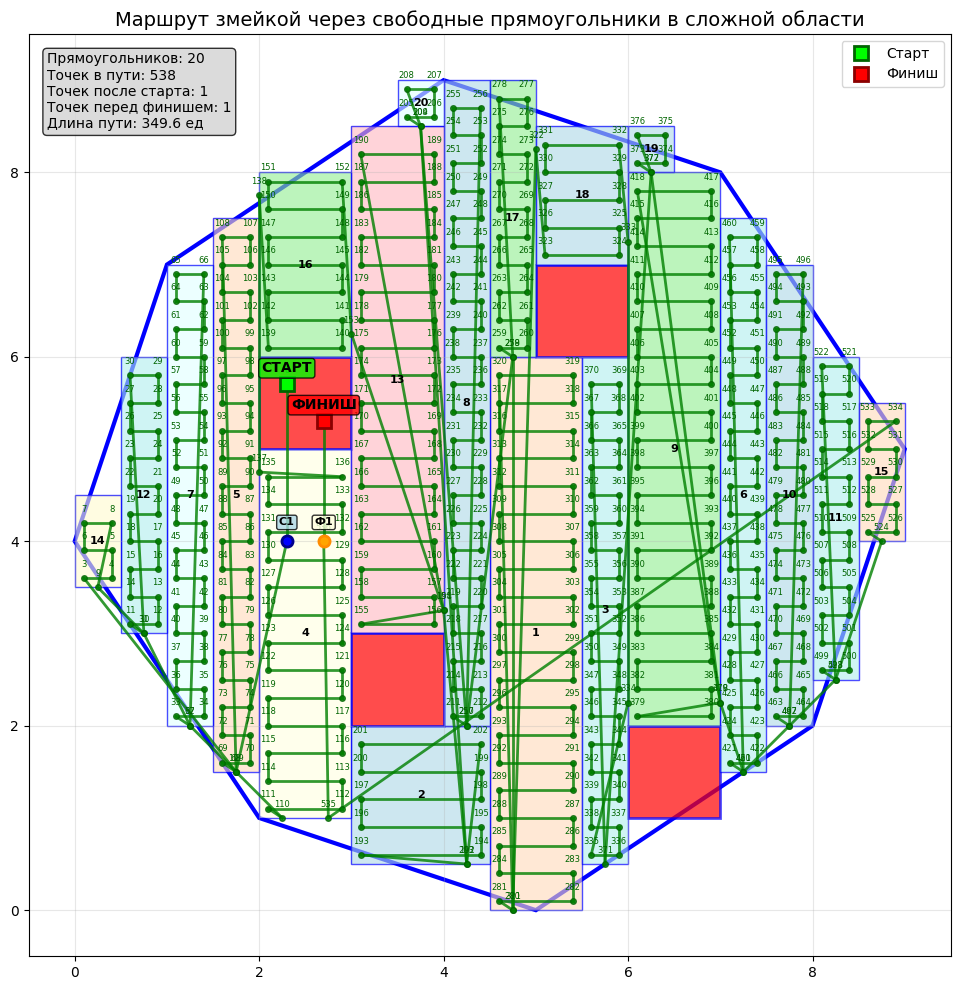

In [75]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.patches import Polygon, Rectangle
from typing import List, Tuple, Optional
import random

class FreeRectangle:
    def __init__(self, vertices):
        self.vertices = vertices
        self.center = np.mean(vertices, axis=0)
        self.x1 = min(v[0] for v in vertices)
        self.x2 = max(v[0] for v in vertices)
        self.y1 = min(v[1] for v in vertices)
        self.y2 = max(v[1] for v in vertices)
        self.width = self.x2 - self.x1
        self.height = self.y2 - self.y1

    def get_boundary_points(self, step=0.5) -> List[np.ndarray]:
        """Генерирует точки на границе прямоугольника"""
        points = []
        # Нижняя граница
        x_bottom = np.arange(self.x1 + step/2, self.x2, step)
        points.extend([np.array([x, self.y1]) for x in x_bottom])

        # Правая граница
        y_right = np.arange(self.y1 + step/2, self.y2, step)
        points.extend([np.array([self.x2, y]) for y in y_right])

        # Верхняя граница
        x_top = np.arange(self.x2 - step/2, self.x1, -step)
        points.extend([np.array([x, self.y2]) for x in x_top])

        # Левая граница
        y_left = np.arange(self.y2 - step/2, self.y1, -step)
        points.extend([np.array([self.x1, y]) for y in y_left])

        return points

class Obstacle:
    def __init__(self, vertices):
        self.vertices = vertices
        self.x1 = min(v[0] for v in vertices)
        self.x2 = max(v[0] for v in vertices)
        self.y1 = min(v[1] for v in vertices)
        self.y2 = max(v[1] for v in vertices)

    def get_bounds(self) -> Tuple[float, float, float, float]:
        return self.x1, self.y1, self.x2, self.y2

class SnakeTrajectoryPlanner:
    def __init__(self, border_offset=0.1, step_y=0.1):
        self.border_offset = border_offset
        self.step_y = step_y

    def generate_snake_trajectory(self, rectangle: FreeRectangle) -> List[np.ndarray]:
        """Генерирует траекторию змейкой внутри прямоугольника"""
        x_min, x_max = rectangle.x1, rectangle.x2
        y_min, y_max = rectangle.y1, rectangle.y2

        x_coords = np.array([x_min + self.border_offset, x_max - self.border_offset])
        y_coords = np.arange(y_min + self.border_offset, y_max - self.border_offset, self.step_y)

        if len(y_coords) == 0:
            return [rectangle.center]

        points = []
        for i, y in enumerate(y_coords):
            if i % 2 == 0:  # Четные строки - слева направо
                for x in x_coords:
                    points.append(np.array([x, y]))
            else:  # Нечетные строки - справа налево
                for x in reversed(x_coords):
                    points.append(np.array([x, y]))

        return points

class PathFinder:
    def __init__(self, rectangles: List[FreeRectangle], obstacles: List[Obstacle],
                 start_point: np.ndarray, end_point: np.ndarray,
                 start_waypoints: List[np.ndarray] = None, end_waypoints: List[np.ndarray] = None):
        self.rectangles = rectangles
        self.obstacles = obstacles
        self.start_point = start_point
        self.end_point = end_point
        self.start_waypoints = start_waypoints if start_waypoints else []
        self.end_waypoints = end_waypoints if end_waypoints else []
        self.snake_planner = SnakeTrajectoryPlanner()

    def can_connect_directly(self, point1: np.ndarray, point2: np.ndarray) -> bool:
        """Проверяет, можно ли соединить две точки напрямую без пересечения препятствий"""
        for obstacle in self.obstacles:
            if self.line_intersects_obstacle(point1, point2, obstacle):
                return False
        return True

    def line_intersects_obstacle(self, p1: np.ndarray, p2: np.ndarray, obstacle: Obstacle) -> bool:
        """Проверяет пересечение отрезка с препятствием"""
        x1, y1, x2, y2 = obstacle.get_bounds()

        # Проверяем, лежат ли точки внутри препятствия
        if (x1 <= p1[0] <= x2 and y1 <= p1[1] <= y2) or \
           (x1 <= p2[0] <= x2 and y1 <= p2[1] <= y2):
            return True

        # Проверяем пересечение с каждой стороной препятствия
        sides = [
            [(x1, y1), (x2, y1)],  # нижняя
            [(x2, y1), (x2, y2)],  # правая
            [(x2, y2), (x1, y2)],  # верхняя
            [(x1, y2), (x1, y1)]   # левая
        ]

        for side in sides:
            if self.lines_intersect(p1, p2, side[0], side[1]):
                return True

        return False

    def lines_intersect(self, a1: np.ndarray, a2: np.ndarray, b1: Tuple[float, float], b2: Tuple[float, float]) -> bool:
        """Проверяет пересечение двух отрезков"""
        def ccw(A, B, C):
            return (C[1]-A[1]) * (B[0]-A[0]) > (B[1]-A[1]) * (C[0]-A[0])

        return ccw(a1, b1, b2) != ccw(a2, b1, b2) and ccw(a1, a2, b1) != ccw(a1, a2, b2)

    def find_connection_point(self, rect1: FreeRectangle, rect2: FreeRectangle) -> Optional[Tuple[np.ndarray, np.ndarray]]:
        """Находит точки соединения на границах двух прямоугольников"""
        boundary1 = rect1.get_boundary_points()
        boundary2 = rect2.get_boundary_points()

        for point1 in boundary1:
            for point2 in boundary2:
                if self.can_connect_directly(point1, point2):
                    return point1, point2
        return None

    def find_closest_rectangle_to_point(self, point: np.ndarray) -> Optional[FreeRectangle]:
        """Находит ближайший прямоугольник к заданной точке"""
        if not self.rectangles:
            return None

        closest_rect = None
        min_distance = float('inf')

        for rect in self.rectangles:
            distance = np.linalg.norm(rect.center - point)
            if distance < min_distance:
                min_distance = distance
                closest_rect = rect

        return closest_rect

    def find_connection_to_rectangle(self, point: np.ndarray, rect: FreeRectangle) -> Optional[np.ndarray]:
        """Находит точку соединения от точки к прямоугольнику"""
        boundary_points = rect.get_boundary_points()

        for boundary_point in boundary_points:
            if self.can_connect_directly(point, boundary_point):
                return boundary_point
        return None

    def build_complete_path(self) -> List[np.ndarray]:
        """Строит полный путь через все прямоугольники с начальной и конечной точками"""
        if len(self.rectangles) < 1:
            return []

        sorted_rects = sorted(self.rectangles, key=lambda r: (r.center[0], r.center[1]))
        complete_path = []

        # Добавляем стартовую точку и точки после старта
        complete_path.append(self.start_point)

        # Добавляем точки после старта
        for waypoint in self.start_waypoints:
            complete_path.append(waypoint)

        # Находим ближайший прямоугольник к последней точке после старта
        last_start_point = self.start_waypoints[-1] if self.start_waypoints else self.start_point
        start_rect = self.find_closest_rectangle_to_point(last_start_point)
        if start_rect:
            start_connection = self.find_connection_to_rectangle(last_start_point, start_rect)
            if start_connection is not None:
                complete_path.append(start_connection)

        # Обрабатываем все прямоугольники
        for i, rect in enumerate(sorted_rects):
            snake_path = self.snake_planner.generate_snake_trajectory(rect)

            if i == 0:
                complete_path.extend(snake_path)
            else:
                prev_rect = sorted_rects[i-1]
                connection = self.find_connection_point(prev_rect, rect)

                if connection is not None:
                    point1, point2 = connection
                    complete_path.extend([point1, point2])
                    complete_path.extend(snake_path)
                else:
                    complete_path.extend(snake_path)

        # Добавляем соединение с точками перед финишем
        if self.end_waypoints:
            end_rect = self.find_closest_rectangle_to_point(self.end_waypoints[0])
        else:
            end_rect = self.find_closest_rectangle_to_point(self.end_point)

        if end_rect and complete_path:  # Проверяем, что путь не пустой
            last_rect_point = complete_path[-1]
            end_connection = self.find_connection_to_rectangle(last_rect_point, end_rect)
            if end_connection is not None:
                complete_path.append(end_connection)

        # Добавляем точки перед финишем
        for waypoint in self.end_waypoints:
            complete_path.append(waypoint)

        # Добавляем конечную точку
        complete_path.append(self.end_point)

        return complete_path

class SpacePartitioner:
    def __init__(self, boundary_polygon: np.ndarray):
        self.boundary_polygon = boundary_polygon
        self.x_min = min(v[0] for v in boundary_polygon)
        self.x_max = max(v[0] for v in boundary_polygon)
        self.y_min = min(v[1] for v in boundary_polygon)
        self.y_max = max(v[1] for v in boundary_polygon)
        self.width = self.x_max - self.x_min
        self.height = self.y_max - self.y_min

    def point_in_polygon(self, point: np.ndarray, polygon: np.ndarray) -> bool:
        """Проверяет, находится ли точка внутри полигона"""
        x, y = point
        n = len(polygon)
        inside = False

        p1x, p1y = polygon[0]
        for i in range(1, n + 1):
            p2x, p2y = polygon[i % n]
            if y > min(p1y, p2y):
                if y <= max(p1y, p2y):
                    if x <= max(p1x, p2x):
                        if p1y != p2y:
                            xinters = (y - p1y) * (p2x - p1x) / (p2y - p1y) + p1x
                        if p1x == p2x or x <= xinters:
                            inside = not inside
            p1x, p1y = p2x, p2y

        return inside

    def merge_rectangles(self, obstacles: List[Obstacle]) -> List[FreeRectangle]:
        """Объединяет ячейки сетки в большие прямоугольники внутри границы"""
        # Создаем сетку точек
        grid_step = 0.5  # Шаг сетки
        x_coords = np.arange(self.x_min, self.x_max + grid_step, grid_step)
        y_coords = np.arange(self.y_min, self.y_max + grid_step, grid_step)

        # Создаем сетку ячеек
        grid = np.zeros((len(y_coords)-1, len(x_coords)-1), dtype=bool)

        # Помечаем ячейки, которые пересекаются с препятствиями или находятся вне границы
        for i in range(len(x_coords)-1):
            for j in range(len(y_coords)-1):
                cell_center = np.array([(x_coords[i] + x_coords[i+1])/2,
                                      (y_coords[j] + y_coords[j+1])/2])

                # Проверяем, находится ли центр ячейки внутри границы
                if not self.point_in_polygon(cell_center, self.boundary_polygon):
                    grid[j, i] = True
                    continue

                # Проверяем пересечение с препятствиями
                for obstacle in obstacles:
                    obs_x_min, obs_y_min, obs_x_max, obs_y_max = obstacle.get_bounds()
                    cell_x_min, cell_x_max = x_coords[i], x_coords[i+1]
                    cell_y_min, cell_y_max = y_coords[j], y_coords[j+1]

                    if (cell_x_min < obs_x_max and cell_x_max > obs_x_min and
                        cell_y_min < obs_y_max and cell_y_max > obs_y_min):
                        grid[j, i] = True
                        break

        quadrilaterals = []
        visited = np.zeros_like(grid)

        # Объединяем ячейки в прямоугольники
        for j in range(len(y_coords)-1):
            i = 0
            while i < len(x_coords)-1:
                if visited[j, i] or grid[j, i]:
                    i += 1
                    continue

                width = 1
                while (i + width < len(x_coords)-1 and
                       not visited[j, i + width] and
                       not grid[j, i + width]):
                    width += 1

                height = 1
                can_extend_height = True
                while can_extend_height and j + height < len(y_coords)-1:
                    for w in range(width):
                        if visited[j + height, i + w] or grid[j + height, i + w]:
                            can_extend_height = False
                            break
                    if can_extend_height:
                        height += 1

                # Создаем прямоугольник
                quad = [
                    [x_coords[i], y_coords[j]],
                    [x_coords[i + width], y_coords[j]],
                    [x_coords[i + width], y_coords[j + height]],
                    [x_coords[i], y_coords[j + height]]
                ]

                quadrilaterals.append(FreeRectangle(quad))

                # Помечаем ячейки как посещенные
                for h in range(height):
                    for w in range(width):
                        if j + h < len(y_coords)-1 and i + w < len(x_coords)-1:
                            visited[j + h, i + w] = True

                i += width

        return quadrilaterals

class Visualizer:
    def __init__(self, boundary_polygon: np.ndarray):
        self.boundary_polygon = boundary_polygon
        self.x_min = min(v[0] for v in boundary_polygon)
        self.x_max = max(v[0] for v in boundary_polygon)
        self.y_min = min(v[1] for v in boundary_polygon)
        self.y_max = max(v[1] for v in boundary_polygon)
        self.fig, self.ax = plt.subplots(figsize=(12, 10))

    def get_random_light_color(self):
        """Генерирует случайный светлый цвет"""
        colors = ['lightpink', 'lightblue', 'lightyellow', 'lightgreen', 'lightcyan',
                  'lavender', 'peachpuff', 'paleturquoise', 'lemonchiffon', 'mistyrose']
        return random.choice(colors)

    def plot_scene(self, rectangles: List[FreeRectangle], obstacles: List[Obstacle],
                   path: List[np.ndarray], start_point: np.ndarray, end_point: np.ndarray,
                   start_waypoints: List[np.ndarray], end_waypoints: List[np.ndarray]):
        """Визуализирует всю сцену с прямоугольниками, препятствиями и путем"""
        self.ax.clear()

        # Рисуем внешнюю границу сложной фигуры синей сплошной линией
        boundary_patch = Polygon(self.boundary_polygon, fill=False,
                               edgecolor='blue', linewidth=3)
        self.ax.add_patch(boundary_patch)

        # Рисуем препятствия
        for obstacle in obstacles:
            obstacle_patch = Polygon(obstacle.vertices, fill=True,
                                   facecolor='red', alpha=0.7,
                                   edgecolor='blue', linewidth=2)
            self.ax.add_patch(obstacle_patch)

        # Рисуем свободные прямоугольники со случайными светлыми цветами и синим контуром
        for i, rect in enumerate(rectangles):
            # Внутренняя заливка случайным светлым цветом
            quad_patch = Polygon(rect.vertices, fill=True,
                               facecolor=self.get_random_light_color(), alpha=0.6)
            self.ax.add_patch(quad_patch)

            # Синий контур прямоугольника
            border_patch = Polygon(rect.vertices, fill=False,
                                 edgecolor='blue', linewidth=1, alpha=0.7)
            self.ax.add_patch(border_patch)

            # Подписываем прямоугольники
            center = rect.center
            self.ax.text(center[0], center[1], str(i+1), ha='center', va='center',
                        fontsize=8, fontweight='bold')

        # Рисуем полный путь зеленым цветом
        if len(path) > 1:
            path_array = np.array(path)

            # Рисуем линии пути зеленым цветом
            for i in range(len(path_array) - 1):
                p1, p2 = path_array[i], path_array[i+1]
                self.ax.plot([p1[0], p2[0]], [p1[1], p2[1]], color='green',
                           linewidth=2, alpha=0.8)

            # Рисуем точки пути зеленым цветом
            self.ax.plot(path_array[:, 0], path_array[:, 1], 'o', markersize=4,
                       markerfacecolor='green', markeredgecolor='darkgreen',
                       markeredgewidth=1, alpha=0.8)

            # Подписываем все точки пути
            for i, point in enumerate(path):
                self.ax.text(point[0], point[1] + 0.1, f'{i}',
                           ha='center', va='bottom', fontsize=6, color='darkgreen')

        # Рисуем стартовую и финишную точки
        self.ax.plot(start_point[0], start_point[1], 's', markersize=10,
                   markerfacecolor='lime', markeredgecolor='darkgreen',
                   markeredgewidth=2, label='Старт')
        self.ax.plot(end_point[0], end_point[1], 's', markersize=10,
                   markerfacecolor='red', markeredgecolor='darkred',
                   markeredgewidth=2, label='Финиш')

        # Рисуем точки после старта (синие)
        for i, waypoint in enumerate(start_waypoints):
            self.ax.plot(waypoint[0], waypoint[1], 'o', markersize=8,
                       markerfacecolor='blue', markeredgecolor='darkblue',
                       markeredgewidth=2)
            self.ax.text(waypoint[0], waypoint[1] + 0.15, f'C{i+1}',
                       ha='center', va='bottom', fontsize=8, fontweight='bold',
                       bbox=dict(boxstyle="round,pad=0.2", facecolor='lightblue', alpha=0.8))

        # Рисуем точки перед финишем (оранжевые)
        for i, waypoint in enumerate(end_waypoints):
            self.ax.plot(waypoint[0], waypoint[1], 'o', markersize=8,
                       markerfacecolor='orange', markeredgecolor='darkorange',
                       markeredgewidth=2)
            self.ax.text(waypoint[0], waypoint[1] + 0.15, f'Ф{i+1}',
                       ha='center', va='bottom', fontsize=8, fontweight='bold',
                       bbox=dict(boxstyle="round,pad=0.2", facecolor='lightyellow', alpha=0.8))

        # Подписываем старт и финиш
        self.ax.text(start_point[0], start_point[1] + 0.1, 'СТАРТ',
                   ha='center', va='bottom', fontsize=10, fontweight='bold',
                   bbox=dict(boxstyle="round,pad=0.2", facecolor='lime', alpha=0.8))
        self.ax.text(end_point[0], end_point[1] + 0.1, 'ФИНИШ',
                   ha='center', va='bottom', fontsize=10, fontweight='bold',
                   bbox=dict(boxstyle="round,pad=0.2", facecolor='red', alpha=0.8))

        # Настройки отображения
        margin = 0.5
        self.ax.set_xlim(self.x_min - margin, self.x_max + margin)
        self.ax.set_ylim(self.y_min - margin, self.y_max + margin)
        self.ax.set_aspect('equal')
        self.ax.grid(True, alpha=0.3)
        self.ax.set_title('Маршрут змейкой через свободные прямоугольники в сложной области', fontsize=14)
        self.ax.legend(loc='upper right')

        # Добавляем информационную панель
        info_text = (f'Прямоугольников: {len(rectangles)}\n'
                    f'Точек в пути: {len(path)}\n'
                    f'Точек после старта: {len(start_waypoints)}\n'
                    f'Точек перед финишем: {len(end_waypoints)}\n'
                    f'Длина пути: {self._calculate_path_length(path):.1f} ед')

        self.ax.text(0.02, 0.98, info_text, transform=self.ax.transAxes, fontsize=10,
                    verticalalignment='top',
                    bbox=dict(boxstyle="round", facecolor='lightgray', alpha=0.8))

    def _calculate_path_length(self, path: List[np.ndarray]) -> float:
        """Вычисляет общую длину пути"""
        if len(path) < 2:
            return 0.0
        total_length = 0.0
        for i in range(len(path) - 1):
            total_length += np.linalg.norm(path[i+1] - path[i])
        return total_length

    def show(self):
        """Показывает график"""
        plt.tight_layout()
        plt.show()

def main():
    # Параметры
    BORDER_OFFSET = 0.1
    STEP_Y = 0.3

    # Создаем сложную границу из 8 точек (форма звезды/сложного многоугольника)

    boundary_polygon = np.array([
        [2, 1],    # Точка 1
        [5, 0],    # Точка 2
        [8, 2],    # Точка 3
        [9, 5],    # Точка 4
        [7, 8],    # Точка 5
        [4, 9],    # Точка 6
        [1, 7],    # Точка 7
        [0, 4]     # Точка 8
    ])

    # boundary_polygon = np.array([
    #     [1, 1],    # Точка 1
    #     [7, 1],    # Точка 2
    #     [7, 7],    # Точка 3
    #     [1, 7],    # Точка 4
    # ])

    # Основные препятствия внутри сложной границы
    obstacles_data = [
        [[3, 2], [4, 2], [4, 3], [3, 3]],
        [[6, 1], [7, 1], [7, 2], [6, 2]],
        [[5, 6], [6, 6], [6, 7], [5, 7]],
        [[2, 5], [3, 5], [3, 6], [2, 6]],
    ]

    obstacles = [Obstacle(np.array(obs)) for obs in obstacles_data]

    # Точки старта и финиша
    start_point = np.array([2.3, 5.7])
    end_point = np.array([2.7, 5.3])

    # Точки после старта
    start_waypoints = [
        np.array([2.3, 4.0])
    ]

    # Точки перед финишем
    end_waypoints = [
        np.array([2.7, 4.0])
    ]

    # Разбиваем пространство внутри сложной границы
    partitioner = SpacePartitioner(boundary_polygon)
    rectangles = partitioner.merge_rectangles(obstacles)

    # Настраиваем планировщик
    snake_planner = SnakeTrajectoryPlanner(border_offset=BORDER_OFFSET, step_y=STEP_Y)
    path_finder = PathFinder(rectangles, obstacles, start_point, end_point,
                           start_waypoints, end_waypoints)
    path_finder.snake_planner = snake_planner

    # Строим путь
    path = path_finder.build_complete_path()

    # Визуализируем
    visualizer = Visualizer(boundary_polygon)
    visualizer.plot_scene(rectangles, obstacles, path, start_point, end_point,
                         start_waypoints, end_waypoints)
    visualizer.show()

if __name__ == "__main__":
    main()